# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

- Se o bloco abaixo der erro no seu computador, pesquise pelo programa "prompt Anaconda" e execute os seguintes códigos de instalação:
    - pip install seaborn
    - pip install plotly

In [236]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

### Agora vamos importar as bases de dados

Para isso, vamos criar um dicionário com os 3 primeiros caracteres com os nomes dos meses e o número correspondente daquele mês.

Para cada arquivo da base de dados a gente vai importar o arquivo e criar uma coluna na base de dados com o mês e o ano de cada informação

In [191]:
# meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

# caminho_bases = pathlib.Path('dataset')

# base_airbnb = pd.DataFrame()

# for arquivo in caminho_bases.iterdir():
#     nome_mes = arquivo.name[:3]
#     mes = meses[nome_mes]
    
#     ano = arquivo.name[-8:]
#     ano = int(ano.replace('.csv', ''))
    
#     df = pd.read_csv(caminho_bases / arquivo.name, low_memory=False)
#     df['ano'] = ano
#     df['mes'] = mes
#     base_airbnb = base_airbnb.append(df)

# # display(base_airbnb)
# colunas = ['host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type',
#            'accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','guests_included','extra_people','minimum_nights',
#            'maximum_nights','number_of_reviews','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = pd.read_parquet('Base_airbnb.parquet')

### Agora vamos começar os tratamentos

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais
    
- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:


### Tratar Valores Faltando

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise
- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN

- Agora vamos excluir as linhas vazias

In [192]:
base_airbnb = base_airbnb.dropna()

# print(base_airbnb.shape)
# print(base_airbnb.isnull().sum())

### Verificar Tipos de Dados em cada coluna

- Precisamos fazer isso porque às vezes o Python está lendo como texto alguma coluna que deveria ser um número, então precisamos corrigir

In [193]:
# print(base_airbnb.dtypes)
# print('-'*60)
# print(base_airbnb.iloc[0])

- Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna.

In [194]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
#extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)
#verificando os tipos
print(base_airbnb.dtypes)

C:\Users\ruana\AppData\Local\Temp\ipykernel_15600\4022817052.py:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

C:\Users\ruana\AppData\Local\Temp\ipykernel_15600\4022817052.py:6: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

In [195]:
plt.figure(figsize=(15, 10))
# sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')
# print(base_airbnb.corr())

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

### Definição de Funções para Análise de Outliers

Vamos definir algumas funções para ajudar na análise de outliers das colunas

In [196]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def exluir_outliers(df, nome_coluna):
    qtd_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]

    linhas_removidas = qtd_linhas - (df.shape[0])
    return df, linhas_removidas

In [197]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp

def diagrama_caixa(coluna):
    # Calculando os quartis
    Q1 = coluna.quantile(0.25)
    Q3 = coluna.quantile(0.75)
    IQR = Q3 - Q1
    
    # Limites para os dados sem outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrando os dados sem outliers
    dados_sem_outliers = coluna[(coluna >= limite_inferior) & (coluna <= limite_superior)]
    # Criando subplots
    fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Com Outliers', 'Sem Outliers'))
    # Box plot com outliers
    fig.add_trace(go.Box(x=coluna, boxmean='sd', name='Com Outliers'), row=1, col=1)
    # Box plot sem outliers
    fig.add_trace(go.Box(x=dados_sem_outliers, boxmean='sd', name='Sem Outliers'), row=1, col=2)
    # Atualizando layout
    fig.update_layout(title='Diagrama de Caixa', yaxis_title=coluna.name)
    fig.show()
    
def histograma(coluna):
    # Criando histograma
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=coluna, histnorm='probability density'))
    fig.update_layout(title='Histograma', xaxis_title=coluna.name, yaxis_title='Densidade de Probabilidade')
    fig.show()

def grafico_barra(coluna):
        # Calculando os quartis
    Q1 = coluna.quantile(0.25)
    Q3 = coluna.quantile(0.75)
    IQR = Q3 - Q1
    
    # Limites para os dados sem outliers
    limite_superior = Q3 + 1.5 * IQR

    # Filtrando os dados sem outliers
    dados_sem_outliers = coluna[coluna <= limite_superior]

    fig = px.bar(x = dados_sem_outliers.value_counts().index, y = dados_sem_outliers.value_counts())
    fig.update_layout(title='Gráfico de Barra', xaxis_title=coluna.name, yaxis_title='Contagem')
    fig.show()

### Price

In [198]:
# diagrama_caixa(base_airbnb['price'])
# histograma(base_airbnb['price'])

Como estamos construindo um modelo para imóveis comuns, acredito que os valorea acima do limite superior serão apenas de apartementos de altissimo luxo, e por isso podemos exluir esses outliers

In [199]:
base_airbnb, qtd_linhas = exluir_outliers(base_airbnb, 'price')

# print(f'{qtd_linhas} linhas removidas.')

### Extra people

In [200]:
# diagrama_caixa(base_airbnb['extra_people'])
# histograma(base_airbnb['extra_people'])

In [201]:
base_airbnb, qtd_linhas = exluir_outliers(base_airbnb, 'extra_people')

# print(f'{qtd_linhas} linhas removidas.')

### host_is_superhost

In [202]:
# diagrama_caixa(base_airbnb['host_listings_count'])
# grafico_barra(base_airbnb['host_listings_count'])

In [203]:
base_airbnb, qtd_linhas = exluir_outliers(base_airbnb, 'host_listings_count')

# print(f'{qtd_linhas} linhas removidas.')

### accommodates

In [204]:
# diagrama_caixa(base_airbnb['accommodates'])
# grafico_barra(base_airbnb['accommodates'])

In [205]:
base_airbnb, qtd_linhas = exluir_outliers(base_airbnb, 'accommodates')

# print(f'{qtd_linhas} linhas removidas.')

### bathrooms

In [206]:
# diagrama_caixa(base_airbnb['bathrooms'])
# grafico_barra(base_airbnb['bathrooms'])

In [207]:
base_airbnb, qtd_linhas = exluir_outliers(base_airbnb, 'bathrooms')

# print(f'{qtd_linhas} linhas removidas.')

### bedrooms

In [208]:
# diagrama_caixa(base_airbnb['bedrooms'])
# grafico_barra(base_airbnb['bedrooms'])

In [209]:
base_airbnb, qtd_linhas = exluir_outliers(base_airbnb, 'bedrooms')

# print(f'{qtd_linhas} linhas removidas.')

### beds

In [210]:
# diagrama_caixa(base_airbnb['beds'])
# grafico_barra(base_airbnb['beds'])

In [211]:
base_airbnb, qtd_linhas = exluir_outliers(base_airbnb, 'beds')

# print(f'{qtd_linhas} linhas removidas.')

### guests_included

In [212]:
# diagrama_caixa(base_airbnb['guests_included'])
# grafico_barra(base_airbnb['guests_included'])

In [213]:
del base_airbnb['guests_included']

### minimum_nights

In [214]:
# diagrama_caixa(base_airbnb['minimum_nights'])
# grafico_barra(base_airbnb['minimum_nights'])

In [215]:
base_airbnb, qtd_linhas = exluir_outliers(base_airbnb, 'minimum_nights')

# print(f'{qtd_linhas} linhas removidas.')

### maximum_nights

In [216]:
# diagrama_caixa(base_airbnb['maximum_nights'])
# grafico_barra(base_airbnb['maximum_nights'])

In [217]:
del base_airbnb['maximum_nights']

### number_of_reviews

In [218]:
# diagrama_caixa(base_airbnb['number_of_reviews'])
# grafico_barra(base_airbnb['number_of_reviews'])

In [219]:
del base_airbnb['number_of_reviews']

### Colunas de texto

- property_type

In [220]:
# print(base_airbnb['property_type'].value_counts())

# plt.figure(figsize = (15,5))
# grafico = sns.countplot(data = base_airbnb,x = 'property_type')
# grafico.tick_params(axis=  'x', rotation = 90)

In [221]:
tabela_tipo_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipo_casa.index:
    if tabela_tipo_casa[tipo] < 2_000:
        colunas_agrupar.append(tipo)
# print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros'

# base_airbnb['property_type'].value_counts()

In [222]:
# plt.figure(figsize = (15,5))
# grafico = sns.countplot(data = base_airbnb,x = 'property_type')
# grafico.tick_params(axis=  'x', rotation = 90)

In [223]:
# print(base_airbnb['cancellation_policy'].value_counts())

# plt.figure(figsize = (15,5))
# grafico = sns.countplot(data = base_airbnb,x = 'cancellation_policy')
# grafico.tick_params(axis=  'x', rotation = 90)

# tabela_tipo_casa = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipo_casa.index:
    if tabela_tipo_casa[tipo] < 10_000:
        colunas_agrupar.append(tipo)
# print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'

# base_airbnb['cancellation_policy'].value_counts()

In [224]:
# plt.figure(figsize = (15,5))
# grafico = sns.countplot(data = base_airbnb,x = 'bed_type')
# grafico.tick_params(axis=  'x', rotation = 90)

# tabela_tipo_casa = base_airbnb['bed_type'].value_counts()
# colunas_agrupar = []

for tipo in tabela_tipo_casa.index:
    if tabela_tipo_casa[tipo] < 10_000:
        colunas_agrupar.append(tipo)
# print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Outros'

# base_airbnb['bed_type'].value_counts()

- amenities

In [225]:
len(base_airbnb['amenities'].iloc[0].split(','))

25

In [226]:
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

In [227]:
del base_airbnb['amenities']

In [228]:
# diagrama_caixa(base_airbnb['n_amenities'])
# grafico_barra(base_airbnb['n_amenities'])

In [229]:
base_airbnb, qtd_linhas = exluir_outliers(base_airbnb, 'n_amenities')

### MAPAS

In [230]:
amostra = base_airbnb.sample(n = 100000)

centro_mapa = {'lat' : amostra.latitude.mean(), 'lon' : amostra.longitude.mean()}

fig = px.density_mapbox(amostra, lat = 'latitude', lon = 'longitude',
                                    z = 'price', radius = 2.5, center = centro_mapa, zoom = 10,
                                    mapbox_style='white-bg')

### Tratamento de Colunas de Valores de Texto

### Encoding

Precisamor Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

In [231]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()

for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == 't', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == 'f', coluna] = 0

In [232]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

base_airbnb_cod = pd.get_dummies(data = base_airbnb_cod, columns = colunas_categorias)

base_airbnb_cod.head()

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,0,0,0,1,0,0,1,0,0,0
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,0,0,0,1,0,0,1,0,0,0
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,0,0,0,1,0,0,1,0,0,0
5,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,0,0,0,1,0,0,1,0,0,0
6,1,1.0,-22.981269,-43.190457,2,1.0,1.0,2.0,219.0,80.0,...,0,0,0,1,0,0,1,0,0,0


### Modelo de Previsão

In [233]:
def avalisar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}: \nR²: {r2}\nRSME: {RSME}'

- Escolha dos modelos a serem testados
    - Random Forest
    - Linear Regression
    - Extra Tree

In [238]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest' : modelo_rf,
           'LinearRegression' : modelo_lr,
           'ExtraTrees' : modelo_et}

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis = 1)

- Separar os dados em treino em teste e treinar o modelo

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

for nome_modelo, modelo in modelos.items():
    #Treinar 
    modelo.fit(X_train, y_train)
    #Testas
    previsao = modelo.predict(X_test)
    print(avalisar_modelo(nome_modelo, y_test, previsao))


Modelo RandomForest: 
R²: 0.9724982034893339
RSME: 43.97589582026836
Modelo LinearRegression: 
R²: 0.32729203035172816
RSME: 217.49408452019563
Modelo ExtraTrees: 
R²: 0.975137168621276
RSME: 41.812819650568905


### Análise do Melhor Modelo

1. Modelo RandomForest: 
    - R²: 0.9724982034893339
    - RSME: 43.97589582026836
2. Modelo LinearRegression: 
    - R²: 0.32729203035172816
    - RSME: 217.49408452019563
3. **Modelo ExtraTrees:**
    - **R²: 0.975137168621276**
    - **RSME: 41.812819650568905**
    1. Sem a coluna 'is_business_travel_ready'
        - **Modelo ExtraTrees:**
        -    **R²: 0.9750987529759223**
        -    **RSME: 41.84510974744912**

### Ajustes e Melhorias no Melhor Modelo

In [246]:
# print(modelo_et.feature_importances_)
# print(X_train.columns)

importancia = pd.DataFrame(data = modelo_et.feature_importances_, index=X_train.columns)

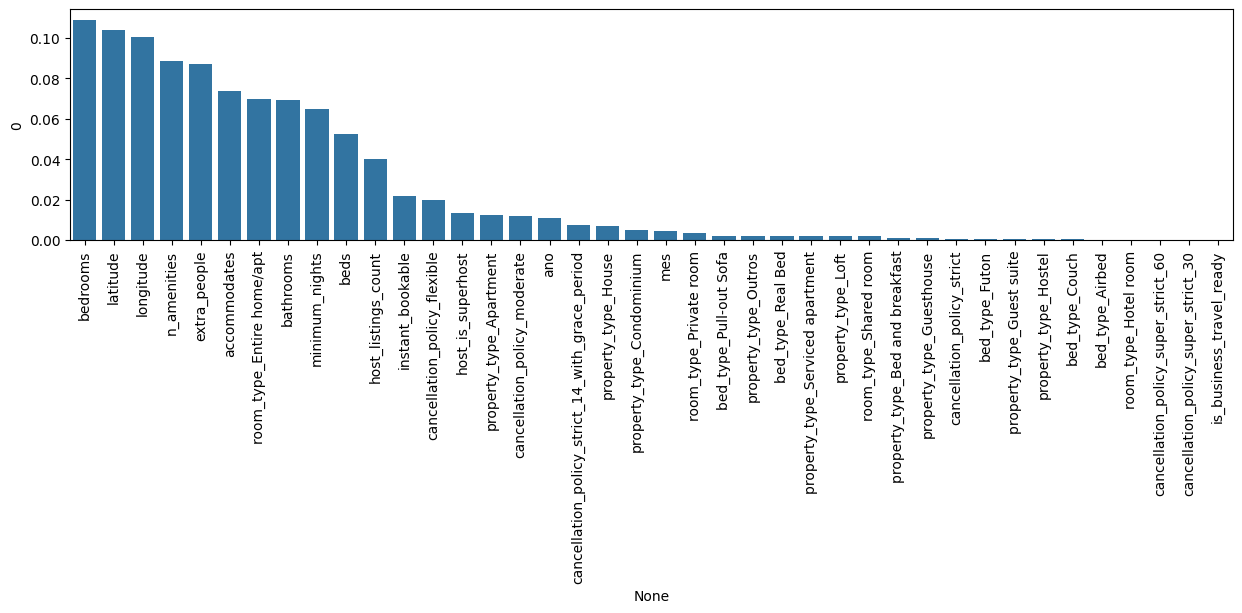

In [266]:
importancia = importancia.sort_values(by = 0, ascending=False)

plt.figure(figsize = (15,3))
ax = sns.barplot(x = importancia.index, y = importancia[0])
ax.tick_params(axis = 'x', rotation = 90)

### Ajustes Finais no Modelo

- is_business_travel ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [275]:
modelo_et = ExtraTreesRegressor()

# del base_airbnb_cod['is_business_travel_ready']

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

#Treinar 
modelo_et.fit(X_train, y_train)
#Testas
previsao = modelo_et.predict(X_test)
print(avalisar_modelo(nome_modelo, y_test, previsao))

Modelo ExtraTrees: 
R²: 0.9750987529759223
RSME: 41.84510974744912


In [280]:
importancia.index

Index(['bedrooms', 'latitude', 'longitude', 'n_amenities', 'extra_people',
       'accommodates', 'room_type_Entire home/apt', 'bathrooms',
       'minimum_nights', 'beds', 'host_listings_count', 'instant_bookable',
       'cancellation_policy_flexible', 'host_is_superhost',
       'property_type_Apartment', 'cancellation_policy_moderate', 'ano',
       'cancellation_policy_strict_14_with_grace_period',
       'property_type_House', 'property_type_Condominium', 'mes',
       'room_type_Private room', 'bed_type_Pull-out Sofa',
       'property_type_Outros', 'bed_type_Real Bed',
       'property_type_Serviced apartment', 'property_type_Loft',
       'room_type_Shared room', 'property_type_Bed and breakfast',
       'property_type_Guesthouse', 'cancellation_policy_strict',
       'bed_type_Futon', 'property_type_Guest suite', 'property_type_Hostel',
       'bed_type_Couch', 'bed_type_Airbed', 'room_type_Hotel room',
       'cancellation_policy_super_strict_60',
       'cancellation_policy

In [283]:
base_teste = base_airbnb_cod.copy()

for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis = 1)
base_teste.columns


Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60'],
      dtype='object')

In [284]:

y = base_teste['price']
X = base_teste.drop('price', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

#Treinar 
modelo_et.fit(X_train, y_train)
#Testas
previsao = modelo_et.predict(X_test)
print(avalisar_modelo(nome_modelo, y_test, previsao))

Modelo ExtraTrees: 
R²: 0.9749577778046572
RSME: 41.96339289570144


# Deploy do Projeto

- Passo 1 -> Criar arquivo do Modelo (joblib)<br>
- Passo 2 -> Escolher a forma de deploy:
    - Arquivo Executável + Tkinter
    - Deploy em Microsite (Flask)
    - Deploy apenas para uso direto Streamlit
- Passo 3 -> Outro arquivo Python (pode ser Jupyter ou PyCharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy feito

In [287]:
X['Price'] = y
X.to_csv('dados_final.csv')

O modelo de ML fica armazenado como um arquivo (.joblib), que pode ser utilizado em outros códigos e projetos futuros

In [289]:
import joblib
joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']